In [38]:
import sys
import pandas as pd 
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'


MODULES_PATH = "../modules"
if MODULES_PATH not in sys.path:
    sys.path.append(MODULES_PATH)

from assets_etl import *

## Preprocessing

In [39]:
import pickle 
with open('../Data/sentiment_dict.pickle', 'rb') as f:
    tweet_dict = pickle.load(f)

In [40]:
tweet_dict.keys()

dict_keys(['TESLA', 'TWITTER', 'BITCOIN', 'DOGE', 'ETH'])

In [41]:
def apply_to_each_df(tweet_dict, *funcs) -> None:
    """
    Applies a list of functions to each dataframe in the tweet_dict (in place)
    @param tweet_dict: dictionary of dataframes
    @param *funcs: list of functions to apply to each dataframe
    @return: None
    """
    for security in tweet_dict.keys():
        for sentiment, df in tweet_dict[security].items():
            for func in funcs:
                df = func(df,security, sentiment)
                tweet_dict[security][sentiment] = df   


In [42]:
import datetime as dt
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2022,12,31)

date_format = '%Y-%m-%d'

def remove_outside_dates(df, *args):
    df = df[(df['day'] >= start_date) & (df['day'] <= end_date)]
    return df

def remove_day_column_rename_created_at(df, *args):
    df = df.drop(columns=['created_at'])
    df = df.rename(columns={'day': 'created_at'})
    return df

def set_created_at_as_index(df, *args):
    df = df.set_index('created_at')
    return df

# Pre-process dataframe and restrict date range
apply_to_each_df(tweet_dict, 
                    remove_outside_dates,
                    remove_day_column_rename_created_at, set_created_at_as_index)

In [43]:
import yfinance as yf

ticker_names = {
    'TESLA': {'ticker':'TSLA', 'type':'stock', 'permno': 93436},
    'TWITTER': {'ticker': 'TWTR', 'type': 'stock', 'permno': 14295},
    'BITCOIN': {'ticker':'BTC-USD', 'type':'crypto'},
    'ETH': {'ticker':'ETH-USD', 'type':'crypto'},
    'DOGE': {'ticker':'DOGE-USD', 'type':'crypto'},
}


In [44]:
#Download data for each security
"""wrds_loader = WRDSLoader(username="safae")
for security in ticker_names.keys():
    ticker = ticker_names[security]['ticker']
    type_ = ticker_names[security]['type']

    path = f'../Data/securities/'

    if type_ == 'crypto':
        yf.download(ticker, start=start_date.strftime(
            date_format), end=end_date.strftime(date_format),
                    progress=False, interval='1d').to_csv(path + f'{security}.csv')

    else: 

        permno = ticker_names[security]['permno']
        
        wrds_loader.download_stock_data({ticker: permno}, from_=start_date.strftime(
            date_format), to=end_date.strftime(date_format), save_to=path, close_conn=False)
wrds_loader.close()"""
pass

In [45]:
#Load data for each security
returns_dict = {}
for security in ticker_names.keys():
  ticker = ticker_names[security]['ticker']
  type_ = ticker_names[security]['type']

  path = f'../Data/securities/'

  df = None

  if type_ == 'crypto':
    df = pd.read_csv(path + f'{ticker}.csv', parse_dates=True)

    df = preproc_btc_for_bsts(df)

  else:
    df = pd.read_csv(path + f'{ticker}_2010_2022.csv', parse_dates=True)

    df = preproc_tsla_for_bsts(df)

    df.rename(columns={'index': 'date'}, inplace=True)
  
  
  df = df[['date', 'ret']]
  df['log_return'] = np.log(df['ret'] + 1)
  df.set_index('date', inplace=True)

  returns_dict[security] = df


In [46]:
# Add returns before and after tweet to the df
from datetime import timedelta
pre_effect_window = 14
post_effect_window = 7


def add_log_returns_before_and_after_tweet(df,*args):
    
    security = args[0]
    prices_df = returns_dict[security]

    df['log_returns_before_tweet'] = df.index.map(
        lambda x: prices_df.loc[x - timedelta(days=pre_effect_window): x - timedelta(days=1)]['log_return'].values
        )

    df['log_returns_after_tweet'] = df.index.map(
        lambda x: prices_df.loc[x + timedelta(days=1):  x + timedelta(days=post_effect_window)]['log_return'].values)
    
    df = df[(df['log_returns_before_tweet'].map(len) == pre_effect_window)
            & (df['log_returns_after_tweet'].map(len) == post_effect_window)]

    return df


apply_to_each_df(tweet_dict, add_log_returns_before_and_after_tweet)

## Time-series analysis (t-test)

In [47]:
# perform t-test on the returns/prices before and after the tweet
from scipy.stats import ttest_ind

def perform_t_test(df, *args):

    def ttt(x):
    
        before = np.array(x['log_returns_before_tweet'].tolist())
        after = np.array(x['log_returns_after_tweet'].tolist())


        return ttest_ind(
            before, after)

    df['t_stat'] = df.apply(lambda x: ttt(x) , axis=1)
    df['p_value'] = df['t_stat'].apply(lambda x: x[1])
    df['t_stat'] = df['t_stat'].apply(lambda x: x[0])

    return df 

apply_to_each_df(tweet_dict, perform_t_test)

In [48]:
tweet_dict['TESLA']['neutral'].head()

,id,text,hashtags,mentions,cashtags,is_reply,retweet_count,reply_count,like_count,quote_count,...,text_length,processed_text,finbert_sentiment,month,tweetbert_sentiment,vader_sentiment,log_returns_before_tweet,log_returns_after_tweet,t_stat,p_value
created_at,,,,,,,,,,,,,,,,,,,,,
2022-12-22,1605971794208337920,RT @Tesla: Track Mode coming to Model Y Perfor...,[],[Tesla],[],True,3475,0,0,0,...,10,track mode model perform,neutral,2022,neutral,neutral,"[-0.0034533869894747575, 0.03183337965789328, ...","[-0.017706675532212255, -0.04257901527098906, ...",0.494924,0.626329
2022-12-21,1605712434102030339,Sustainable cars powered by sustainable energy...,[],[],[],True,11548,11637,152274,1306,...,7,sustain car sustain energi,neutral,2022,neutral,neutral,"[-0.03267127298325752, -0.0034533869894747575,...","[-0.0930231189665288, -0.017706675532212255, -...",1.834514,0.082287
2022-12-20,1605229127874842626,RT @Tesla: Every Tesla has an electronic power...,[],[Tesla],[],True,3019,0,0,0,...,20,everi tesla electron powertrain instant torqu ...,neutral,2022,neutral,neutral,"[-0.014519754857137872, -0.03267127298325752, ...","[-0.0016704490415595592, -0.0930231189665288, ...",2.872618,0.009747
2022-12-17,1604193864515887105,"To be clear, all user actions will factor into...",[],[CommunityNotes],[],True,3776,5618,46676,1443,...,38,clear user action nn model tweet account twe...,neutral,2022,neutral,neutral,"[-0.020897906033629947, -0.0430994942369464, -...","[-0.017478475446652354, -0.0023992055650661694...",0.804647,0.430977
2022-12-16,1603860632842907648,@GerberKawasaki Tesla is executing better than...,[],[GerberKawasaki],[],True,3764,4114,54068,670,...,19,tesla better ever feder reserv real prob...,neutral,2022,neutral,neutral,"[0.0008214584072647443, -0.020897906033629947,...","[-0.032788615503700075, -0.017478475446652354,...",0.952066,0.353019


In [49]:
#Write results of significance test to file
with open('results.txt', 'a') as f:
    f.write(
        f'For Window Size: {pre_effect_window} days before and {post_effect_window} days after\n')
    
    f.write('Percentge of significant p-values for each security and sentiment:\n')
    for security in tweet_dict.keys():
        f.write(f'{security.capitalize()}\n')
        for sentiment, df in tweet_dict[security].items():
            current_df = tweet_dict[security][sentiment]
            f.write(f"  {sentiment}: {np.mean(current_df['p_value'] < 0.05)}\n")
    
    f.write('\n\n')

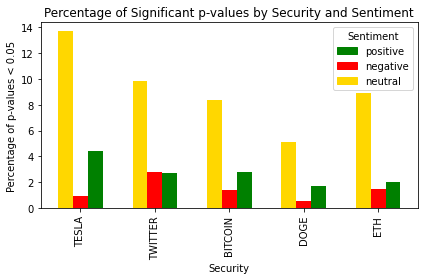

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors for each sentiment
sentiment_colors = {'positive': 'green',
                    'negative': 'red', 'neutral': '#FFD700'}

# Initialize empty lists to store security names, sentiments, and p-value counts
securities = []
sentiments = []
p_value_percentages = []
bar_colors = []

# Iterate over securities and sentiments
for security in tweet_dict.keys():
    sentiment_list = []
    p_value_list = []
    total_tweets = 0
    for sentiment, df in tweet_dict[security].items():
        current_df = tweet_dict[security][sentiment]
        sentiment_list.append(sentiment)
        p_value_count = np.sum(current_df['p_value'] < 0.05)
        p_value_list.append(p_value_count)
        total_tweets += len(current_df)
    securities.append(security)
    sentiments.append(sentiment_list)
    p_value_percentages.append(
        [p_value_count / total_tweets * 100 for p_value_count in p_value_list])
    bar_colors.extend([sentiment_colors[s] for s in sentiment_list])

# Plotting
fig, ax = plt.subplots()
width = 0.2  # Width of each bar
x = np.arange(len(securities))

for i, sentiment_list in enumerate(sentiments):
    x_shift = x[i] - (len(sentiment_list) - 1) * width / 2
    for j, sentiment in enumerate(sentiment_list):
        ax.bar(x_shift + j * width,
               p_value_percentages[i][j], width=width, color=sentiment_colors[sentiment])

ax.set_xticks(x)
ax.set_xticklabels(securities, rotation=90)
ax.set_ylabel("Percentage of p-values < 0.05")
ax.set_xlabel("Security")
ax.set_title("Percentage of Significant p-values by Security and Sentiment")

# Create a legend for sentiments and colors
legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color, label=sentiment)
                   for sentiment, color in sentiment_colors.items()]
ax.legend(handles=legend_elements, title='Sentiment')

plt.tight_layout()
plt.show()


## Autocorrelation analysis

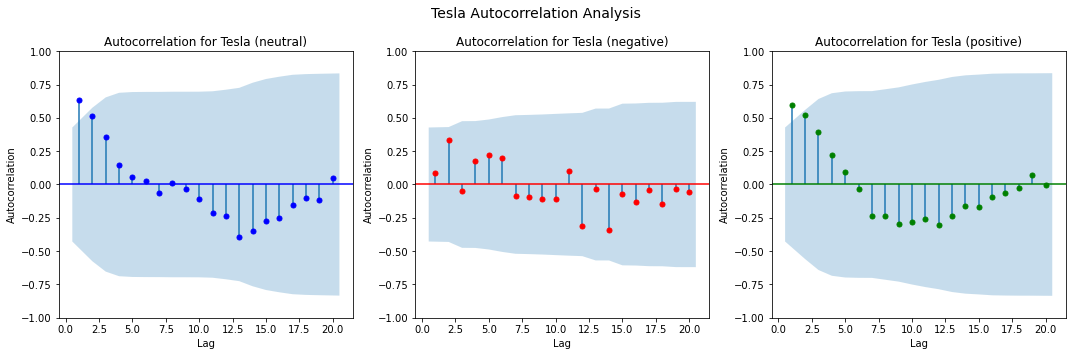

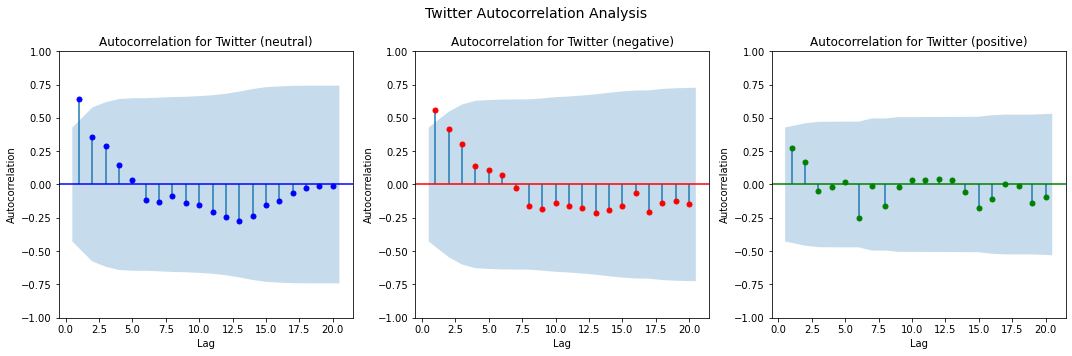

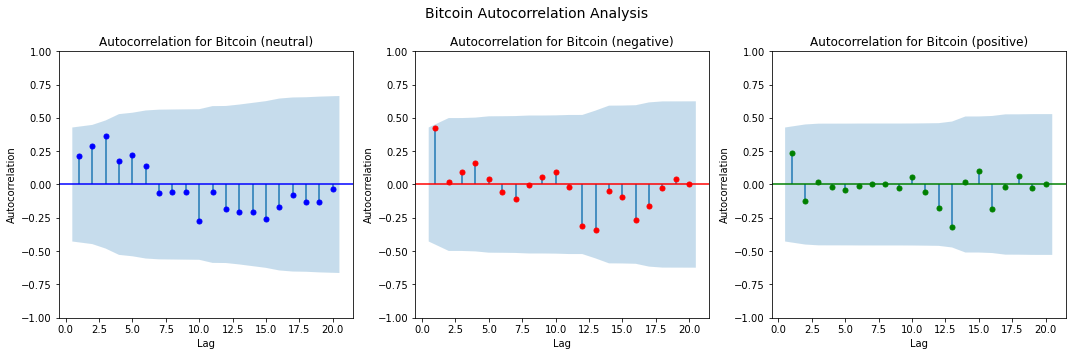

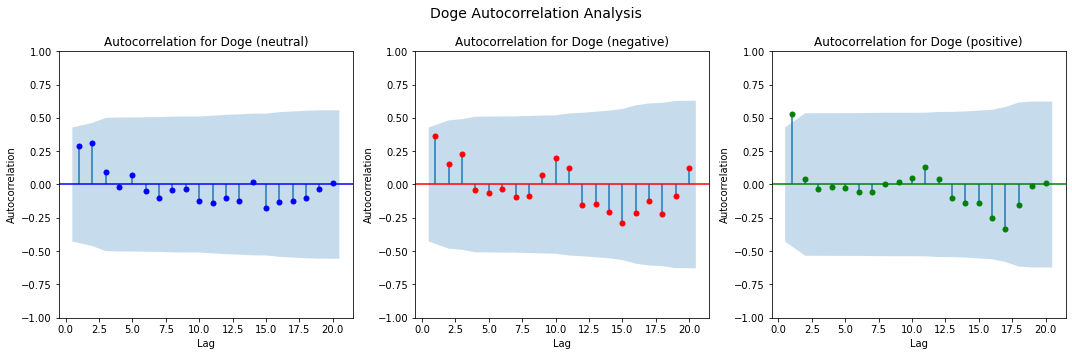

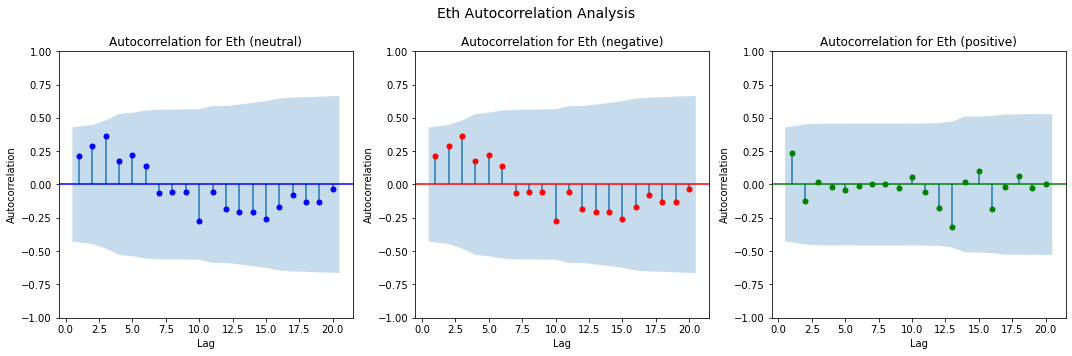

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Define colors for each sentiment
sentiment_colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

for security, df_dict in tweet_dict.items():
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (sentiment, df) in enumerate(df_dict.items()):
        ax = axes[i]  # Select the appropriate subplot for each sentiment

        df_sorted = df.sort_values(by='p_value', ascending=True)
        df_sorted = df_sorted[df_sorted['p_value'] < 0.05]
        df_sorted = df_sorted.head(10)
        df_sorted['all_returns'] = df_sorted.apply(lambda x: np.concatenate(
            (x['log_returns_before_tweet'], x['log_returns_after_tweet'])), axis=1)
        returns = df_sorted['all_returns'].values

        plot_acf(returns[0], lags=20,
                 title=f"Autocorrelation for {security.capitalize()} ({sentiment})",
                 zero=False, color=sentiment_colors[sentiment], ax=ax)  # Use the specific subplot for each sentiment

        # Customize the subplot settings for each sentiment
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')

    fig.suptitle(
        f"{security.capitalize()} Autocorrelation Analysis", fontsize=14)
    plt.tight_layout()
    plt.show()
